In [56]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import os
import matplotlib.pyplot as plt

# Hyper-parameters 
input_size = 784 #  MNIST image is 28x28
hidden_size = 100 
num_classes = 10 # number image 0-9
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# use cpu device = torch.device('cpu')


In [57]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])

In [58]:

#MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size = 64,
                                                shuffle = True,
                                                 num_workers=2)

test_loader= torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size = 64,
                                               shuffle = True,
                                                num_workers=2)
print(len(train_dataset))



60000


[tensor(8), tensor(4), tensor(9), tensor(5), tensor(0), tensor(6), tensor(1), tensor(1), tensor(8), tensor(6), tensor(5), tensor(2), tensor(5), tensor(1), tensor(2), tensor(8), tensor(5), tensor(7), tensor(3), tensor(9), tensor(3), tensor(2), tensor(9), tensor(0), tensor(3), tensor(5), tensor(9), tensor(8), tensor(1), tensor(9), tensor(1), tensor(4), tensor(4), tensor(1), tensor(4), tensor(5), tensor(9), tensor(2), tensor(6), tensor(7), tensor(0), tensor(1), tensor(5), tensor(8), tensor(3), tensor(6), tensor(1), tensor(5), tensor(3), tensor(5), tensor(7), tensor(3), tensor(9), tensor(9), tensor(2), tensor(6), tensor(3), tensor(8), tensor(0), tensor(9), tensor(9), tensor(7), tensor(9), tensor(0)]


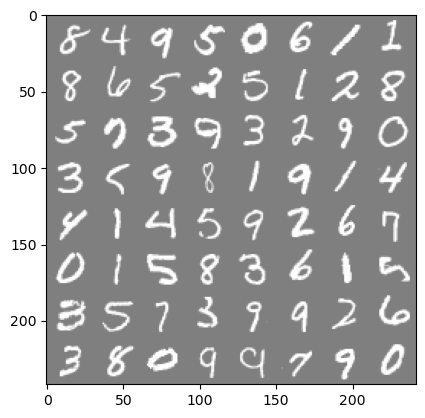

In [60]:
images, labels = next(iter(train_loader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)



In [64]:
# converlutional neural network 

class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128,1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p=0.5),
                                         torch.nn.Linear(1024, 10))
    def forward(self, x):
        out = self.conv1(x)
        out = out.view(-1, 14*14*128)
        out = self.dense(x)
        return x
    

In [66]:
# create model
model = Model()

print(model)


Model(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [68]:
# Loss and optimizer

cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

n_epochs = 5

PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

#model.load_state_dict(torch.load('model_parameter.pkl'))


In [70]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, num_epochs))
    print("-"*10)
    for data in train_loader:
        X_train, y_train = data
        X_train, y_train = Variable(X_train), Variable(y_train)
        outputs = model(X_train)
        _,pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = cost(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        running_correct += torch.sum(pred == y_train.data)
    testing_correct = 0
    
    for data in test_loader:
        X_test, y_test = data
        X_test, y_test = Variable(X_test), Variable(y_test)
        outputs = model(X_test)
        _, pred = torch.max(outputs.data, 1)
        testing_correct += torch.sum(pred == y_test.data)
    print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(running_loss/len(data_train),
                                                                                      100*running_correct/len(data_train),
                                                                                      100*testing_correct/len(data_test)))

torch.save(model.state_dict(), PATH)

Epoch 0/10
----------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 25088x1024)

In [71]:
# Test the model
# No gradients for the test phase 
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        labels = labels
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 784]